In [1]:
import numpy as np
import pandas as pd
import thermo
import chemicals
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, FlashPureVLS, VaporPressure, PropertyCorrelationsPackage
from thermo import FlashVLN

In [2]:
def F_to_R(F):
    return F + 459.67

def R_to_F(R):
    return R - 459.67

def gal_to_bbl(gal):
    return gal / 42

def bbl_to_gal(bbl):
    return bbl * 42

def psi_to_Pa(psi):
    return psi * 6894.745

def Pa_to_psi(pa):
    return pa / 6894.745

def F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def K_to_F(K):
    return (K - 273.15) * 1.8 + 32

https://thermo.readthedocs.io/index.html#

https://thermo.readthedocs.io/thermo.mixture.html

https://chemicals.readthedocs.io/chemicals.vapor_pressure.html#vapor-pressure-estimation-correlations

# Gas viscosity always works.
# Liquid viscosity seems to work at any Temperature @14.7 psia

In [388]:
from thermo import ChemicalConstantsPackage, CEOSGas, CEOSLiquid, SRKMIX, FlashVLN, PropertyCorrelationsPackage, HeatCapacityGas
from thermo import FlashVL
from thermo.interaction_parameters import IPDB
import pint

comp = dict([
    ('methane', 0.6), 
    ('propane', 0.2),
    ('hexane', 0.2),
    ('water', 0.0),
])
total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs)
gas = CEOSGas(SRKMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
liq = CEOSLiquid(SRKMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
flashN = FlashVLN(constants, properties, liquids=[liq, liq], gas=gas) # if dealing with water, fill [liq, liq] twice.
                  
T = F_to_K(50)
P = psi_to_Pa(2000)
                  
res = flashN.flash(T=T, P=P, zs=list(comp.values()))

if res.phase_count == 3:
    gas_frac = res.betas[0]
    light_liq_frac = res.betas[1]
    heavy_liq_frac = res.betas[2]
elif res.phase_count == 2:
    gas_frac = res.betas[0]
    light_liq_frac = res.betas[1]
    heavy_liq_frac = 0
elif res.phase_count == 1:
    gas_frac = res.VF
    light_liq_frac = res.LF
    heavy_liq_frac = 0    

ureg = pint.UnitRegistry()
    
print('Mole Frac Vapor           : %.3f %s' % (gas_frac, ''))
print('Mole Frac Light Liquid    : %.3f %s' % (light_liq_frac, ''))
try:
    print('Mole Frac Heavy Liquid    : %.3f' % heavy_liq_frac)  # need to ensure that the phase count =< 3
except:
    pass
print()
print('Molecular Weight          : %.3f %s' % (res.MW(), ''))
print('Mass Density              : %.3f %s' % (res.rho_mass(), '[kg/m^3]')) 
print('Molar Density             : %.3f %s' % (res.rho(), '[mol/m^3]')) 
print('Compressibility           : %.3f %s' % (res.Z(), ''))
print()
print('Molar Enthalpy            : %.3f %s' % (res.H(), '[J/mol]'))
print('Mass Enthalpy             : %.3f %s' % (res.H_mass(), '[J/kg]'))
print()
print('Molar Heat Capacity       : %.3f %s' % (res.Cp(), '[J/(mol*K)]'))
print('Mass Heat Capacity        : %.3f %s' % (res.Cp_mass(), '[J/(kg*K)]'))
print()
print('Cp/Cv Ratio               : %.3f %s' % (res.Cp_Cv_ratio(), ''))
print('Cp/Cv Ratio Ideal Gas     : %.3f %s' % (res.Cp_Cv_ratio_ideal_gas(), ''))
print()
print('Dynamic Viscosity         : %.8f %s' % (res.mu(), '[Pa*s]'))
mu_cP = ureg('%.15f pascal * second' % res.mu()).to('centipoise')._magnitude
print('Dynamic Viscosity         : %.8f %s' % (mu_cP, '[cP]'))

print('Kinematic Viscosity       : %.8f %s' % (res.kinematic_viscosity(), '[m^2/s]'))
mu_cSt = ureg('%.15f m^2 / second' % res.nu()).to('centistokes')._magnitude
print('Kinematic Viscosity       : %.8f %s' % (mu_cSt , '[cSt]'))
print()
print('Phase Count               : %s' % res.phase_count)

Mole Frac Vapor           : 0.000 
Mole Frac Light Liquid    : 1.000 
Mole Frac Heavy Liquid    : 0.000

Molecular Weight          : 35.680 
Mass Density              : 414.295 [kg/m^3]
Molar Density             : 11611.507 [mol/m^3]
Compressibility           : 0.504 

Molar Enthalpy            : -12699.110 [J/mol]
Mass Enthalpy             : -355920.020 [J/kg]

Molar Heat Capacity       : 101.228 [J/(mol*K)]
Mass Heat Capacity        : 2837.135 [J/(kg*K)]

Cp/Cv Ratio               : 1.545 
Cp/Cv Ratio Ideal Gas     : 1.153 

Dynamic Viscosity         : 0.00003518 [Pa*s]
Dynamic Viscosity         : 0.03518320 [cP]
Kinematic Viscosity       : 0.00000008 [m^2/s]
Kinematic Viscosity       : 0.08492310 [cSt]

Phase Count               : 1


In [389]:
# gas viscosity
a = thermo.viscosity.ViscosityGasMixture(ViscosityGases=res.ViscosityGases).calculate(T=T, P=P, zs=res.zs, ws=res.ws(), method='LINEAR')

mu_cP = ureg('%.15f pascal * second' % a).to('centipoise')._magnitude
print('Dynamic Viscosity         : %.8f %s' % (mu_cP, '[cP]'))

Dynamic Viscosity         : 0.00908440 [cP]


In [390]:
# liquid viscosity - LINEAR
b = thermo.viscosity.ViscosityLiquidMixture(MWs=res.MWs, ViscosityLiquids=res.ViscosityLiquids).calculate(
    T=T, P=P, zs=res.zs, ws=res.ws(), method='LINEAR')

mu_cP = ureg('%.15f pascal * second' % b).to('centipoise')._magnitude
print('Dynamic Viscosity         : %.8f %s' % (mu_cP, '[cP]'))

Dynamic Viscosity         : 0.11247271 [cP]


In [391]:
# liquid viscosity - LOGARITHM
b1 = thermo.viscosity.ViscosityLiquidMixture(MWs=res.MWs, ViscosityLiquids=res.ViscosityLiquids).calculate(
    T=T, P=P, zs=res.zs, ws=res.ws(), method='Logarithmic mixing, molar')

mu_cP = ureg('%.15f pascal * second' % b1).to('centipoise')._magnitude
print('Dynamic Viscosity         : %.8f %s' % (mu_cP, '[cP]'))

Dynamic Viscosity         : 0.03518320 [cP]


In [372]:
mu_cP = ureg('%.15f pascal * second' % b).to('centipoise')._magnitude
print('Dynamic Viscosity         : %.8f %s' % (mu_cP, '[cP]'))

Dynamic Viscosity         : 0.11247271 [cP]


In [373]:
c = chemicals.viscosity.Lorentz_Bray_Clarke(T=T, P=P, Vm=res.V(), zs=res.zs, MWs=res.MWs, Tcs=res.Tcs, Pcs=res.Pcs, Vcs=res.Vcs)
c

5.7605147901465335e-05

In [374]:
mu_cP = ureg('%.15f pascal * second' % c).to('centipoise')._magnitude
print('Dynamic Viscosity         : %.8f %s' % (mu_cP, '[cP]'))

Dynamic Viscosity         : 0.05760515 [cP]


In [375]:
mw = ChemicalConstantsPackage.constants_from_IDs(['hexane']).MWs[0]
Tc = ChemicalConstantsPackage.constants_from_IDs(['hexane']).Tcs[0]
Pc = ChemicalConstantsPackage.constants_from_IDs(['hexane']).Pcs[0]
omega = ChemicalConstantsPackage.constants_from_IDs(['hexane']).omegas[0]

d = thermo.viscosity.ViscosityLiquid(CASRN=name_to_cas('hexane'), MW=mw, Tc=Tc, Pc=Pc, omega=omega).calculate(T, 'LETSOU_STIEL')
d

0.00027637368323144636

In [376]:
mu_cP = ureg('%.15f pascal * second' % d).to('centipoise')._magnitude
print('Dynamic Viscosity         : %.8f %s' % (mu_cP, '[cP]'))

Dynamic Viscosity         : 0.27637368 [cP]


In [314]:
mw = ChemicalConstantsPackage.constants_from_IDs(['hexane']).MWs[0]
Tc = ChemicalConstantsPackage.constants_from_IDs(['hexane']).Tcs[0]
Pc = ChemicalConstantsPackage.constants_from_IDs(['hexane']).Pcs[0]
omega = ChemicalConstantsPackage.constants_from_IDs(['hexane']).omegas[0]

In [185]:
temp = [
    thermo.viscosity.ViscosityGas(CASRN=name_to_cas('methane')),
    thermo.viscosity.ViscosityGas(CASRN=name_to_cas('propane')),
    thermo.viscosity.ViscosityGas(CASRN=name_to_cas('hexane')),
    thermo.viscosity.ViscosityGas(CASRN=name_to_cas('water')),
]

In [ ]:
search_chemical('water')

# Vapor Pressures

In [182]:
def cas_to_name(cas):
    if not isinstance(cas, str):
        raise ValueError("Input must be a string")    
    return ChemicalConstantsPackage.constants_from_IDs([cas]).names[0]

def name_to_cas(name):
    if not isinstance(name, str):
        raise ValueError("Input must be a string")    
    return ChemicalConstantsPackage.constants_from_IDs([name]).CASs[0]

In [112]:
for compound in res.VaporPressures:
    casrn = compound.CASRN
    chem_obj = thermo.Chemical(casrn)
    chem_name = chem_obj.IUPAC_name
    chem_formula = chem_obj.formula
    Vp = Pa_to_psi(compound.calculate(T, method='SANJARI'))
    print('%s:  %.2f [psi]' % (chem_name, Vp))

methane:  1787.30 [psi]
propane:  92.61 [psi]
hexane:  1.47 [psi]
oxidane:  0.12 [psi]


In [150]:
res.VaporPressures[0].CASRN

'74-82-8'

In [247]:
thermo.viscosity.ViscosityGasMixture(ViscosityGases=res.ViscosityGases).calculate(T=T, P=P, zs=res.zs, ws=res.ws(), method='LINEAR')

9.446915775289704e-06

In [219]:
thermo.viscosity.ViscosityLiquid(name_to_cas('water')).calculate(T=T, method='REFPROP_FIT')

0.0013053464984005233

In [218]:
thermo.viscosity.ViscosityLiquid(name_to_cas('hexane')).calculate(T=T, method='REFPROP_FIT')

0.00034726528766853204

In [244]:
thermo.viscosity.ViscosityLiquidMixture(ViscosityLiquids=res.ViscosityLiquids).calculate(T=T, P=P, zs=res.zs, ws=res.ws(), method='Logarithmic mixing, molar')

6.159719452745319e-05

In [245]:
thermo.viscosity.ViscosityLiquidMixture(ViscosityLiquids=res.ViscosityLiquids).calculate(T=T, P=P, zs=res.zs, ws=res.ws(), method='LINEAR')

0.00016538870436184645

## Each component

In [192]:
# Molecular weight
res.MWs

[16.04246, 44.09562, 86.17536, 18.01528]

In [67]:
# liquid-phase only composition
res.liquid_zs

[0.02597294633980149,
 0.2873212862089624,
 0.45442476641378193,
 0.23228100103745417]

In [68]:
# light-liquid only composition
res.lightest_liquid.zs

[0.0334961800776463,
 0.3705513435994461,
 0.5860607124452865,
 0.00989176387762124]

In [69]:
# heavy-liquid only composition
res.heaviest_liquid.zs

[1.7444222273532208e-06,
 7.548731242040851e-08,
 1.7496733398261244e-13,
 0.999998180090286]

In [71]:
# gas mole fraction
res.gas_beta

0.5725377479975445

In [208]:
# mixture mole fraction
res.MWs

[16.04246, 44.09562, 86.17536, 18.01528]

In [209]:
# mixture mass fraction
res.ws()

[0.16588954060865613,
 0.3419831876464334,
 0.44555482395423024,
 0.046572447790680344]

In [21]:
res.ViscosityLiquids[0].calculate(T, P, zs=comp, ws=comp, method='REFPROP_FIT')

TypeError: calculate() got an unexpected keyword argument 'zs'

In [18]:
len(res.ViscosityLiquids)

4

In [24]:
thermo.ViscosityLiquidMixture(ViscosityLiquids=res.ViscosityLiquids).calculate(T, P, zs=comp, ws=comp, method='Laliberte')

AttributeError: 'ViscosityLiquidMixture' object has no attribute 'index_w'

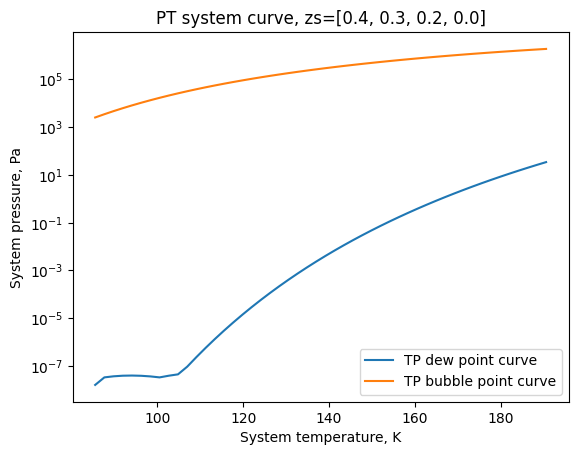

In [244]:
flashN = FlashVL(constants, properties, liquid=liq, gas=gas)
flashN.plot_TP(zs=list(comp.values()));

# Unit Conversions

In [31]:
import pint

ureg = pint.UnitRegistry()
ureg('0.000166488410009 pascal * second').to('centipoise')

0.166488410009 <Unit('centipoise')>

In [30]:
ureg.get_compatible_units('[pressure]')

frozenset({<Unit('sound_pressure_level')>,
           <Unit('barye')>,
           <Unit('pascal')>,
           <Unit('centimeter_H2O')>,
           <Unit('torr')>,
           <Unit('millimeter_Hg')>,
           <Unit('inch_H2O_60F')>,
           <Unit('inch_H2O_39F')>,
           <Unit('centimeter_Hg')>,
           <Unit('foot_H2O')>,
           <Unit('inch_Hg_60F')>,
           <Unit('inch_Hg')>,
           <Unit('pound_force_per_square_inch')>,
           <Unit('technical_atmosphere')>,
           <Unit('bar')>,
           <Unit('standard_atmosphere')>,
           <Unit('kip_per_square_inch')>})

# Pseudos

In [73]:
from scipy.constants import atm

pseudos = ChemicalConstantsPackage(Tcs=[606.28,825.67], Pcs=[25.42*atm, 14.39*atm],
                                   omegas=[0.4019, 0.7987], MWs=[140.0, 325.0])

In [43]:


constants, correlations = ChemicalConstantsPackage.from_IDs(['toluene'])
print('Tb = ', constants.Tbs)
print('Tc = ', constants.Tcs)
print('Pc = ', constants.Pcs)
print('Omega = ', constants.omegas)

T = 284.9278  # K, 52.3 F
Vp = chemicals.vapor_pressure.Lee_Kesler(T, constants.Tcs[0], constants.Pcs[0], constants.omegas[0])
Vp_chemicals = calc_pascal_to_psi(Vp)
print('Vp_chemicals = ', Vp_chemicals)

Tb =  [383.745753146]
Tc =  [591.75]
Pc =  [4126300.0]
Omega =  [0.2657]
Vp_chemicals =  0.2509015664559358


In [44]:
obj = VaporPressure(Pc=constants.Pcs[0], omega=constants.omegas[0], Tc=constants.Tcs[0])
Vp_thermo = obj.calculate(T=T, method='LEE_KESLER_PSAT')
Vp_thermo = calc_pascal_to_psi(Vp_thermo)
print('Vp_thermo = ', Vp_thermo)

Vp_thermo =  0.2509015664559358


In [102]:
constants, correlations = ChemicalConstantsPackage.from_IDs(['methane', 'hexane'])

In [123]:
from thermo import Mixture

comp = dict([
    ('methane', 0.5), 
    ('hexane', 0.5),
])

constants = ChemicalConstantsPackage.constants_from_IDs(comp.keys())

T = calc_F_to_K(39.1)
P = calc_psi_to_pascal(45)

partial_Vps = []
for i, (key, val) in enumerate(comp.items()):
    Vp = VaporPressure(Pc=constants.Pcs[i], omega=constants.omegas[i], Tc=constants.Tcs[i]).calculate(T, 'LEE_KESLER_PSAT')
    Vp = calc_pascal_to_psi(Vp)
    partial_Vp = Vp * val
    partial_Vps.append(partial_Vp)
    
total_Vp = sum(partial_Vps)
#total_Vp = calc_pascal_to_psi(total_Vp)
total_Vp

6020.4729857250395

In [149]:
from thermo import Mixture

comp = dict([
    ('benzene', 0.9), 
    ('toluene', 0.07),
    ('cyclohexane', 0.03),
])

constants = ChemicalConstantsPackage.constants_from_IDs(comp.keys())

T = calc_F_to_K(52.72)

partial_Vps = []
for i, (key, val) in enumerate(comp.items()):
    Vp = VaporPressure(Pc=constants.Pcs[i], omega=constants.omegas[i], Tc=constants.Tcs[i]).calculate(T, 'SANJARI')
    Vp = calc_pascal_to_psi(Vp)
    partial_Vp = Vp * val
    partial_Vps.append(partial_Vp)
    
total_Vp = sum(partial_Vps)
#total_Vp = calc_pascal_to_psi(total_Vp)
total_Vp

0.950105401054541

In [150]:
constants.Pcs

[4907277.0, 4126300.0, 4080500.0]

In [151]:
constants.Tcs

[562.02, 591.75, 553.6]

In [152]:
constants.omegas

[0.211, 0.2657, 0.2096]

In [234]:
from thermo import Mixture

comp = dict([
    ('methane', 0.5), 
    ('hexane', 0.5),
])

comp = dict([
    ('methane', 1), 
])

constants = ChemicalConstantsPackage.constants_from_IDs(comp.keys())

T = calc_F_to_K(32.7947)

T = 298

partial_Vps = []
for i, (key, val) in enumerate(comp.items()):
    Vp = VaporPressure(
        Pc=constants.Pcs[i], 
        omega=constants.omegas[i], 
        Tc=constants.Tcs[i], 
        Tb=constants.Tbs[i]
    ).calculate(T, 'BOILING_CRITICAL')
    
    Vp = calc_pascal_to_psi(Vp)
    partial_Vp = Vp * val
    partial_Vps.append(partial_Vp)
    
total_Vp = sum(partial_Vps)
print('Total Vp [psi] =', round(total_Vp, 2))

Total Vp [psi] = 4673.73


In [232]:
def calc_Vp(comp, T, method='LEE_KESLER_PSAT'):
    constants = ChemicalConstantsPackage.constants_from_IDs(comp.keys())
    partial_Vps = []
    for i, (key, val) in enumerate(comp.items()):
        print(method)
        Vp = VaporPressure(
            Pc=constants.Pcs[i], 
            omega=constants.omegas[i], 
            Tc=constants.Tcs[i], 
            Tb=constants.Tbs[i]
        ).calculate(T, method)

        Vp = calc_pascal_to_psi(Vp)
        partial_Vp = Vp * val
        partial_Vps.append(partial_Vp)

    total_Vp = sum(partial_Vps)
    return total_Vp

In [351]:
from thermo import Mixture

comp = dict([
    ('methane', 0.5), 
    ('hexane', 0.5),
])

comp = dict([
    ('hexane', 1), 
])

constants = ChemicalConstantsPackage.constants_from_IDs(comp.keys())

methods = ['LEE_KESLER_PSAT', 'BOILING_CRITICAL', 'SANJARI']
T = calc_F_to_K(53.24)

for method in methods: 
    Vp = calc_Vp(comp, T, method=method)
    print('Total Vp [psi][%s] = %.10f' % (method, total_Vp))

LEE_KESLER_PSAT
Total Vp [psi][LEE_KESLER_PSAT] = 4673.7299516785
BOILING_CRITICAL
Total Vp [psi][BOILING_CRITICAL] = 4673.7299516785
SANJARI
Total Vp [psi][SANJARI] = 4673.7299516785


In [352]:
T = 800
Tc=constants.Tcs[0]
Pc=constants.Pcs[0]
omega=constants.omegas[0]
Tb=constants.Tbs[0]

print('Tc = ', Tc)
print('Tb = ', Tb)
print('Pc = ', Pc)
print('w = ', omega)

Tc =  507.82
Tb =  341.865616634
Pc =  3044100.0
w =  0.3


In [353]:
calc_pascal_to_psi(chemicals.vapor_pressure.Sanjari(T=T, Tc=Tc, Pc=Pc, omega=omega))

14517.34333617424

In [354]:
calc_pascal_to_psi(chemicals.vapor_pressure.boiling_critical_relation(T=T, Tb=Tb, Tc=Tc, Pc=Pc))

5711.349458464943

In [355]:
calc_pascal_to_psi(chemicals.vapor_pressure.Lee_Kesler(T=T, Tc=Tc, Pc=Pc, omega=omega))

147254.6860510609

In [285]:
7.096 - (516.7 / (38 + 284.37))

5.49318336073456

In [202]:
type(total_Vp)

float

In [217]:
chemicals.vapor_pressure.Ambrose_Walton(T, Tc=constants.Tcs[0], Pc=constants.Pcs[0], omega=constants.omegas[0])

ValueError: math domain error

In [221]:
Tr = T/constants.Tcs[0]
tau = 1.0 - Tr

In [222]:
tau

-0.4333767133351525

In [224]:
np.sqrt(tau)

C:\Users\EricKim\AppData\Local\Temp\ipykernel_15344\3543466345.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(tau)


nan

In [187]:
constants.Tbs

[111.667205474]

In [178]:
calc_pascal_to_psi(constants.Pcs[i])

667.058752716743

In [179]:
constants.Tcs[i]

190.564

In [180]:
constants.omegas[i]

0.01142

In [146]:
constants.Pcs

[4599200.0, 3044100.0]

In [147]:
constants.Tcs

[190.564, 507.82]

In [148]:
constants.omegas

[0.01142, 0.3]

In [121]:
val

0.5

In [100]:
calc_K_to_F(m.Tbubble)

-208.8041562436841

In [93]:
m.Pbubble

262281923.42103288

In [84]:
m.Tcs

[190.564,
 126.192,
 304.1282,
 305.322,
 369.89,
 407.81,
 425.125,
 460.35,
 469.7,
 507.82]

In [83]:
m.rho

4.480225063286449

In [70]:
m.flash(T=T, P=P)

AttributeError: 'Mixture' object has no attribute 'flash'

In [47]:
comp

{'methane': 0.96522,
 'nitrogen': 0.00259,
 'carbon dioxide': 0.00596,
 'ethane': 0.01819,
 'propane': 0.0046,
 'isobutane': 0.00098,
 'butane': 0.00101,
 '2-methylbutane': 0.00047,
 'pentane': 0.00032,
 'hexane': 0.00066}

In [32]:
constants, correlations = ChemicalConstantsPackage.from_IDs(['benzene'])
print('Tb = ', constants.Tbs)
print('Tc = ', constants.Tcs)
print('Pc = ', constants.Pcs)
print('Omega = ', constants.omegas)

T = 284.9278  # K, 52.3 F
Vp = chemicals.vapor_pressure.Lee_Kesler(T, constants.Tcs[0], constants.Pcs[0], constants.omegas[0])
Vp_chemicals = calc_pascal_to_psi(Vp)
print('Vp_chemicals = ', Vp_chemicals)

Tb =  [353.218780053]
Tc =  [562.02]
Pc =  [4907277.0]
Omega =  [0.211]
Vp_chemicals =  0.9698364991508017


In [33]:
constants, correlations = ChemicalConstantsPackage.from_IDs(['cyclohexane'])
print('Tb = ', constants.Tbs)
print('Tc = ', constants.Tcs)
print('Pc = ', constants.Pcs)
print('Omega = ', constants.omegas)

T = 284.9278  # K, 52.3 F
Vp = chemicals.vapor_pressure.Lee_Kesler(T, constants.Tcs[0], constants.Pcs[0], constants.omegas[0])
Vp_chemicals = calc_pascal_to_psi(Vp)
print('Vp_chemicals = ', Vp_chemicals)

Tb =  [353.864948368]
Tc =  [553.6]
Pc =  [4080500.0]
Omega =  [0.2096]
Vp_chemicals =  1.0097356707866914


In [2]:
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, FlashPureVLS, VaporPressure

In [3]:
obj = ChemicalConstantsPackage.constants_from_IDs(['CH4'])
obj.Tbs

[111.667205474]

In [4]:
obj = ChemicalConstantsPackage.constants_from_IDs(['methane'])
obj.Tbs

[111.667205474]

In [5]:
obj = ChemicalConstantsPackage.constants_from_IDs(['hexane'])
obj.Tbs

[341.865616634]

In [6]:
obj = ChemicalConstantsPackage.constants_from_IDs(['toluene'])
obj.Tbs

[383.745753146]

In [7]:
constants, correlations = ChemicalConstantsPackage.from_IDs(['decane'])

In [8]:
print('Tb = ', constants.Tbs)
print('Tc = ', constants.Tcs)
print('Pc = ', constants.Pcs)
print('Omega = ', constants.omegas)

Tb =  [447.270229382]
Tc =  [617.7]
Pc =  [2103000.0]
Omega =  [0.4884]


In [9]:
a = VaporPressure(Tb=constants.Tbs[0], Tc=constants.Tcs[0], Pc=constants.Pcs[0], omega=constants.omegas[0])
T = 284.9278  # K
Vp = a.calculate(T=T, method='IAPWS')

calc_pascal_to_psi(Vp)

NameError: name 'calc_pascal_to_psi' is not defined

In [ ]:
constants, correlations = ChemicalConstantsPackage.from_IDs(['hexane'])

In [ ]:
print('Tb = ', constants.Tbs)
print('Tc = ', constants.Tcs)
print('Pc = ', constants.Pcs)
print('Omega = ', constants.omegas)

In [ ]:
a = VaporPressure(Tb=constants.Tbs[0], Tc=constants.Tcs[0], Pc=constants.Pcs[0], omega=constants.omegas[0])
T = 284.9278  # K
Vp = a.calculate(T=T, method='LEE_KESLER_PSAT')

calc_pascal_to_psi(Vp)

In [10]:
a = VaporPressure(Tb=constants.Tbs[0], Tc=constants.Tcs[0], Pc=constants.Pcs[0], omega=constants.omegas[0])
T = 284.9278  # K
Vp = a.calculate(T=T, method='LEE_KESLER_PSAT')

calc_pascal_to_psi(Vp)

NameError: name 'calc_pascal_to_psi' is not defined

In [11]:
a = VaporPressure(Tb=constants.Tbs[0], Tc=constants.Tcs[0], Pc=constants.Pcs[0], omega=constants.omegas[0])

In [12]:
a = VaporPressure(Tb=constants.Tbs, Tc=constants.Tcs, Pc=constants.Pcs, omega=constants.omegas)
T = 284.9278  # K
Vp = a.calculate(T=T, method='IAPWS')

calc_pascal_to_psi(Vp)

NameError: name 'calc_pascal_to_psi' is not defined

# 0. Inputs

In [2]:
D = 6  # tank diameter (ft)
H = 12  # tank height (ft)
?? = 8  # hold ? ft of product
paint_color = 'white'
liq_level_high = 11.5
liq_level_low = 4.5
liq_flow = 8450  # (gal/yr)

{
    'Vertical Cylinder',
    'Horizontal Cylinder',
    'External Floating Roof Tank',
    'Internal Floatign Roof Tank',
    'Domed Floating Roof Tank',
}

Object ` = 8  # hold ? ft of product` not found.


In [12]:
def calc_Vv(D, Hvo):
    """
    Vv = Tank vapor space volume (ft^3, Eq 1-3)
    D = Tank diameter (ft)
    Hvo = vapor space outage (ft, Eq 1-16)
    """
    return (np.pi / 4) * D ** 2 * Hvo

In [ ]:
def calc_Hvo(Hs, Hl, Hro):
    """
    Hs = Tank shell height (ft, given)
    Hl  = Tank liquid height (ft, given, assumed to be half-filled mostly)
    Hro = roof outage (ft, Eq 1-17)
    """
    return Hs - Hl + Hro

# 1. Utilities

In [98]:
def calc_F_to_R(F):
    return F + 459.67

def calc_R_to_F(R):
    return R - 459.67

def calc_gal_to_bbl(gal):
    return gal / 42

def calc_bbl_to_gal(bbl):
    return bbl * 42

def calc_psi_to_pascal(psi):
    return psi * 6894.745

def calc_pascal_to_psi(pascal):
    return pascal / 6894.745

def calc_F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def calc_K_to_F(K):
    return (K - 273.15) * 1.8 + 32

# 2. Standing Loss

In [ ]:
# Fix roof tank



In [3]:

def calc_T_LA(Hs, D, Ta, Tb, alpa_r, alpha_s, I):
    _1st = (0.5 - 0.8 / (4.4 * Hs/D + 3.8)) * Ta
    _2nd = (0.5 + 0.8 / (4.4 * Hs/D + 3.8)) * Tb
    _3rd = (0.021 * alpha_r * I + 0.013 * Hs/D * alpha_s * I) / (4.4 * Hs/D + 3.8)
    return _1st + _2nd + _3rd 

In [4]:
# December
Hs = 30
D = 15
Ta = calc_F_to_R(95)  # max, Cedar City, Utah
Tb = calc_F_to_R(110)   # liquid bulk
alpha_r = 0.49          # tan
alpha_s = 0.49          # tan
I = 741

In [5]:
calc_T_LA(Hs, D, Ta, Tb, alpha_r, alpha_s, I)

564.4767642857144

## Gekko

In [113]:
from gekko import GEKKO, chemical
m = GEKKO()
c = chemical.Properties(m)

# add compounds
c.compound('hydrogen sulfide')
c.compound('nitrogen')
c.compound('carbon dioxide')
c.compound('Methane')
c.compound('Ethane')
c.compound('propane')
c.compound('isobutane')
c.compound('n-butane')
c.compound('neopentane')
c.compound('isopentane')
c.compound('n-pentane')
c.compound('hexane')

# molecular weight
mw = c.thermo('mw')

# liquid vapor pressure
T = m.Param(value=310)
vps = c.thermo('lvp',T)
m.solve(disp=False)


print(vp)

{'hydrogen sulfide': [2666375.368], 'nitrogen': [32253141.045], 'carbon dioxide': [8337811.4144], 'Methane': [21177601.926], 'Ethane': [5310604.7423], 'propane': [1273976.7398], 'isobutane': [488739.34969], 'n-butane': [346800.85906], 'neopentane': [246224.48508], 'isopentane': [136831.57149], 'n-pentane': [104129.41513], 'hexane': [33115.182972], 'T': [310.0], 'units': 'Pa ', 'property': 'Liquid Vapor Pressure'}


In [107]:
comp = {
    'Hydrogen Sulfide': 0.017,
    'Nitrogen': 0.044,
    'Carbon Dioxide': 0.015,
    'Methane': 1.015,
    'Ethane': 1.641,
    'Propane': 3.608,
    'Isobutane': 1.533,
    'n-Butane': 5.021,
    'Neopentane': 0,
    'Isopentane': 3.132,
    'n-Pentane': 4.126,
    'Hexane': 79.863,
}

In [134]:
vps['hydrogen sulfide'][0]

2666375.368

In [145]:
vps_mol = []
for a, b in zip(comp.keys(), vps.keys()):
    mol = comp[a]
    vp = calc_pascal_to_psi(vps[b][0])
    vps_mol.append(mol * vp)
    if a[0] == 'Hexane':
        break
np.mean(vps_mol)

512.3395549254737

In [30]:
from gekko import GEKKO, chemical
m = GEKKO(remote=False)
c = chemical.Properties(m)
# add compounds
c.compound('hexane')

# liquid vapor pressure
T = m.Param(value=298)
vps = c.thermo('hvap',T)
m.solve(disp=False)

vps

{'hexane': [31547917.631],
 'T': [298.0],
 'units': 'J/kmol ',
 'property': 'Heat of Vaporization'}

In [31]:
2754157176.9 / 1000

2754157.1769000003

In [24]:
from gekko import GEKKO, chemical
m = GEKKO(remote=False)
c = chemical.Properties(m)
# add compounds
c.compound('water')
c.compound('Na2SO4')
# m.open_folder()
# molecular weight
mw = c.thermo('mw')
try:
    m.solve(disp=False)
except:
    # display 'compounds.txt'
    import os
    fid = open(m.path+'/compounds.txt')
    print(fid.read())
    fid.close()
print(mw)

 Any of the following compounds can be referenced by common
   or IUPAC name, CAS number, or chemical formula
 
 Care should be taken when accessing a compound by formula
   because formula names are not unique and the first
   available match will be selected.
 
 Common Name: methane
 IUPAC Name : methane
 CAS Number : 74-82-8
 Formula    : CH4
 
 Common Name: ethane
 IUPAC Name : ethane
 CAS Number : 74-84-0
 Formula    : C2H6
 
 Common Name: propane
 IUPAC Name : propane
 CAS Number : 74-98-6
 Formula    : C3H8
 
 Common Name: isobutane
 IUPAC Name : isobutane
 CAS Number : 75-28-5
 Formula    : C4H10
 
 Common Name: n-butane
 IUPAC Name : butane
 CAS Number : 106-97-8
 Formula    : C4H10
 
 Common Name: n-pentane
 IUPAC Name : pentane
 CAS Number : 109-66-0
 Formula    : C5H12
 
 Common Name: isopentane
 IUPAC Name : isopentane
 CAS Number : 78-78-4
 Formula    : C5H12
 
 Common Name: neopentane
 IUPAC Name : neopentane
 CAS Number : 463-82-1
 Formula    : C5H12
 
 Common Name: n-h

# CoolProp

http://www.coolprop.org/coolprop/HighLevelAPI.html#parameter-table

In [1]:
import CoolProp.CoolProp as CP
import numpy as np
from CoolProp.CoolProp import PropsSI

In [2]:
comp = {
    'Hydrogen Sulfide': 0.017,
    'Nitrogen': 0.044,
    'Carbon Dioxide': 0.015,
    'Methane': 1.015,
    'Ethane': 1.641,
    'Propane': 3.608,
    'Isobutane': 1.533,
    'n-Butane': 5.021,
    'Neopentane': 0,
    'Isopentane': 3.132,
    'n-Pentane': 4.126,
    'Hexane': 79.863,
}

In [3]:
for key, val in comp.items():
    key = key.split(' ')
    if len(key) > 1:
        key = ''.join(key)
    else:
        key = key[0]

    Tcrit = PropsSI('Tcrit', key)
    print(key)

HydrogenSulfide
Nitrogen
CarbonDioxide
Methane
Ethane
Propane
Isobutane
n-Butane
Neopentane
Isopentane
n-Pentane
Hexane


In [6]:
compound = 'Methane'
R = 8.3145
p = calc_psi_to_pascal(14.7)

H_V = PropsSI('H','P', p, 'Q', 1, compound) * PropsSI('M', compound)
H_L = PropsSI('H','P', p, 'Q', 0, compound) * PropsSI('M', compound)

(H_V - H_L) / 1000

8.195019048390064

In [17]:
1 / 16

0.0625

In [19]:
760 * PropsSI('M', 'Hexane')

65.4932736

In [15]:
compound = 'Methane'
R = 8.3145
t = calc_F_to_K(-150)
t_crit = PropsSI('Tcrit', compound)
Tr = t/t_crit

# j/kg * kg/mol = j/kg
H_V = PropsSI('H','T', t, 'Q', 1, compound) * PropsSI('M', compound)
H_L = PropsSI('H','T', t, 'Q', 0, compound) * PropsSI('M', compound)

(H_V - H_L)/1000 # kJ/kg

4.934986930867117

In [12]:
compound = 'Methane'
t_crit = PropsSI('Tcrit', compound)
Ts = np.arange(-280, -120, 10)

H = []
Trs = []
for T in Ts:
    t = calc_F_to_K(T)
    Tr = t / t_crit
    H_V = PropsSI('H','T', t, 'Q', 1, compound) * PropsSI('M', compound) / 1000
    H_L = PropsSI('H','T', t, 'Q', 0, compound) * PropsSI('M', compound) / 1000
    
    H.append(H_V - H_L)
    Trs.append(Tr)

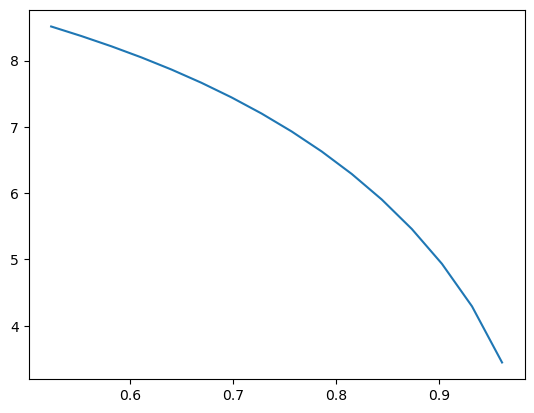

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.plot(Trs, H)

In [195]:
plt.plot(Trs, H)

In [ ]:
for 

In [177]:
t_crit

190.564